In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
import os
import json
from keras.datasets import cifar10

import torch
import torchvision as tv
import torchvision.models as models
import torchvision.transforms as transforms
import inspect 
import torch.nn as nn
import copy

from PIL import Image

matplotlib.style.use('ggplot')
np.random.seed(100)

D:\software\anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\software\anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\software\anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
D:\software\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\software\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\sof

In [2]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, label_list, transform=None):
        super(MyDataset, self).__init__()
        self.imgs = None
        self.targets = None
        self.transform = transform
        for i,j in zip(filenames, labels):
            img = Image.open(i).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            img = torch.unsqueeze(img,0)
            if self.imgs is None:
                self.imgs = img
                self.targets = [j]
            else:
                self.imgs = torch.cat([self.imgs, img])
                self.targets.append(j)
        self.targets = torch.tensor(self.targets)
    
    def __getitem__(self, index):
        return self.imgs[index], self.targets[index]
    
    def __len__(self):
        return len(self.imgs)

In [4]:
# 读取数据
with open('data/imagenet_classes.pkl', 'rb') as f:
    class_names = pickle.load(f)
word_to_class = {w:i for i,w in enumerate(class_names)}

imagenet_class_file=open("data/imagenet_class_index.json",'r')
load_dict = json.load(imagenet_class_file)

imagenet_class_index={}
for item in load_dict:
    #以原始名称为 键 ，类别序号为 值 ，建立字典内容
    imagenet_class_index[load_dict[item][0]]=item

filenames = []
labels = []

file_folder = './data/test1/'
for i in os.listdir(file_folder):
    filenames.append(os.path.join(file_folder, i))
    labels.append(int(imagenet_class_index[i.split('_')[0]]))
    
# originals = [load_img(filename, target_size=(224, 224)) for filename in filenames] # Load an image in PIL format
# images = np.array([img_to_array(original) for original in originals]) # Convert the PIL image to a numpy array

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Scale(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            normalize,
                           ])
val_data = MyDataset(filenames, labels, trans)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=2, num_workers=2)

D:\software\anaconda\lib\site-packages\torchvision\transforms\transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [6]:
# denseNet121 = keras.applications.DenseNet121(weights='imagenet')
# resnet50 = keras.applications.ResNet50(weights='imagenet')
# inceptionV3 = keras.applications.InceptionV3(weights='imagenet')
# denseNet169 = keras.applications.DenseNet169(weights='imagenet')
# denseNet201 = keras.applications.DenseNet201(weights='imagenet')
# VGG16 = keras.applications.VGG16(weights='imagenet')
# VGG19 = keras.applications.VGG19(weights='imagenet')

resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# inception = models.inception_v3(pretrained=True)

In [7]:
def retrieve_name(var):
    ''' utils: get back the name of variables ''' 
    callers_local_vars = inspect.currentframe().f_back.f_locals.items() 
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

def evaluate_models(models, names, x_test, y_test):
    correct_imgs = []
    network_stats = []
    for t, model in enumerate(models):
        print('Evaluating', names[t])

        predictions = model(x_test)
        print(predictions.shape)

        correct = [[names[t], i, label, pred.max().detach().numpy(), pred.detach().numpy()]
                   for i, (label, pred)
                   in enumerate(zip(y_test, predictions))
                   if label == pred.argmax()]
        accuracy = len(correct) / len(x_test)

        correct_imgs += correct
        network_stats += [[names[t], accuracy]]
    return network_stats, correct_imgs

In [8]:

model_list = [vgg16, resnet18]
names = ['VGG16', 'resnet18']
# models = [inceptionV3]

network_stats, correct_imgs = evaluate_models(model_list, names, 
                                              val_loader.dataset.imgs,
                                              val_loader.dataset.targets)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy'])

network_stats 

Evaluating VGG16
torch.Size([10, 1000])
Evaluating resnet18
torch.Size([10, 1000])


,name,accuracy
0,VGG16,0.9
1,resnet18,0.6


# attack

## LinfPGD

In [9]:
from advertorch.attacks import LinfPGDAttack
from advertorch.attacks import PGDAttack

In [10]:
MAX_VALUE = (1 - np.min(normalize.mean))/np.min(normalize.std)
MIN_VALUE = (0 - np.min(normalize.mean))/np.min(normalize.std)


In [11]:
def plot_img(imgs_tensor_, normalize=None):
    imgs_tensor = copy.deepcopy(imgs_tensor_)
    if normalize is not None:
        L = len(normalize.std)
        for i, img in enumerate(imgs_tensor):
            for j in range(L):
                img[j] = img[j] * normalize.std[j] + normalize.mean[j]
    if imgs_tensor.dim() < 4:
        imgs_tensor = torch.unsqueeze(imgs_tensor, 0)
    nums = len(imgs_tensor)
    cols = 4
    rows = nums // cols
    if nums % cols > 0:
        rows += 1
    
    plt.figure(figsize=(1*cols, 1*rows))
    count = 1
    for img in imgs_tensor:
        plt.subplot(rows, cols, count)
        plt.imshow(np.transpose(img,(1,2,0)))
        plt.axis('off')
        count += 1
    plt.show()

In [12]:
adversary_LinfPGD = LinfPGDAttack(model_list[0], 
                                  loss_fn=nn.CrossEntropyLoss(reduction="sum"),
                                  eps=0.03,nb_iter=40, eps_iter=0.01, rand_init=True, 
                                  clip_min=-2.17, clip_max=2.3,targeted=False)

In [13]:
adv_untargeted = adversary_LinfPGD.perturb(val_loader.dataset.imgs,
                                   val_loader.dataset.targets)

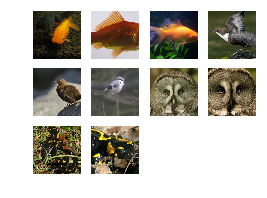

In [14]:
plot_img(val_loader.dataset.imgs, normalize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


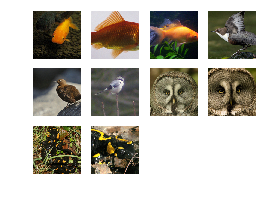

In [15]:
plot_img(adv_untargeted, normalize)

In [16]:
network_stats, correct_imgs = evaluate_models(model_list, names, adv_untargeted, val_loader.dataset.targets)
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy'])

network_stats 

Evaluating VGG16
torch.Size([10, 1000])
Evaluating resnet18
torch.Size([10, 1000])


,name,accuracy
0,VGG16,0.0
1,resnet18,0.6


## PGD

In [17]:
adversary_PGD = PGDAttack(model_list[0], loss_fn=nn.CrossEntropyLoss(reduction="sum"),
                      eps=0.03, nb_iter=40, eps_iter=0.01, rand_init=True, 
                      clip_min=MIN_VALUE, clip_max=MAX_VALUE,targeted=False)

In [18]:
adv_untargeted = adversary_PGD.perturb(val_loader.dataset.imgs,
                                   val_loader.dataset.targets)

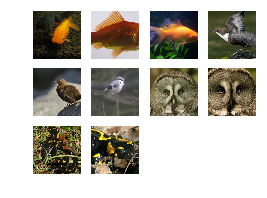

In [19]:
plot_img(val_loader.dataset.imgs, normalize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


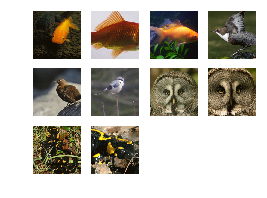

In [20]:
plot_img(adv_untargeted, normalize)

In [21]:
network_stats, correct_imgs = evaluate_models(model_list, names, adv_untargeted, val_loader.dataset.targets)
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy'])
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats 

Evaluating VGG16
torch.Size([10, 1000])
Evaluating resnet18
torch.Size([10, 1000])


,name,accuracy
0,VGG16,0.0
1,resnet18,0.5


## GradientAttack

In [26]:
def eval_model_attacks(models, names, attacks, attack_names, test_x_, test_y):
    network_stats_all = None
    correct_imgs_all = None
    for i, attack in enumerate(attacks):
        test_x = copy.deepcopy(test_x_)
        adv_img = attack.perturb(test_x, test_y)
        network_stats, correct_imgs = evaluate_models(models, 
                                                      names, adv_img, test_y)
        
        network_stats = np.hstack([[[attack_names[i]]]*len(network_stats),network_stats])
        correct_imgs = np.hstack([[[attack_names[i]]]*len(correct_imgs),correct_imgs])
        
        if network_stats_all is None:
            network_stats_all = network_stats
            correct_imgs_all = correct_imgs
        else:
            network_stats_all = np.vstack([network_stats_all, network_stats])
            correct_imgs_all = np.vstack([correct_imgs_all, correct_imgs])
    return network_stats_all, correct_imgs_all
        

In [27]:
attacks = [adversary_LinfPGD, adversary_PGD]
attack_names = ['LinfPGD', 'PGD']

In [28]:
network_stats, correct_imgs = eval_model_attacks(model_list, names, attacks,
                                                 attack_names,
                                                 val_loader.dataset.imgs,
                                                val_loader.dataset.targets)

Evaluating VGG16
torch.Size([10, 1000])
Evaluating resnet18
torch.Size([10, 1000])
Evaluating VGG16
torch.Size([10, 1000])
Evaluating resnet18
torch.Size([10, 1000])


In [29]:
network_stats = pd.DataFrame(network_stats, columns=['attack','model', 'accuracy'])
correct_imgs = pd.DataFrame(correct_imgs, columns=['attack','model', 'img', 'label', 'confidence', 'pred'])
network_stats 

,attack,model,accuracy
0,LinfPGD,VGG16,0.0
1,LinfPGD,resnet18,0.7
2,PGD,VGG16,0.0
3,PGD,resnet18,0.6
